In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import math

%matplotlib inline

## Visualization method

In [2]:
def visualize_trajectory(df_values):
    
    # Unpack X Y Z each trajectory point
    list_of_pos = df_values.values.tolist()
    trajectory = np.array(list_of_pos).T

    #list for x, y and z values
    locX = list(trajectory[0,:])
    locY = list(trajectory[1,:])
    locZ = list(trajectory[2,:])
    
    # Axis limits
    maxX = np.amax(locX) + 1
    minX = np.amin(locX) - 1
    maxY = np.amax(locY) + 1
    minY = np.amin(locY) - 1 
    maxZ = np.amax(locZ) + 1
    minZ = np.amin(locZ) - 1

    # Set styles
    mpl.rc("figure", facecolor="white")
    plt.style.use("seaborn-whitegrid")

    # Plot the figure
    fig = plt.figure(figsize=(8, 6), dpi=100)
    gspec = gridspec.GridSpec(2, 2)
    ZY_plt = plt.subplot(gspec[1,1])
    YX_plt = plt.subplot(gspec[0,1])
    ZX_plt = plt.subplot(gspec[1,0])
    D3_plt = plt.subplot(gspec[0,0], projection='3d')
    
    toffset = 1.0
    
    # Actual trajectory plotting ZX
    
    ZX_plt.set_title("Trajectory (X, Z)", y=toffset)
    ZX_plt.plot(locX, locZ, "--", label="Trajectory", zorder=1, linewidth=1.5, markersize=2)
    ZX_plt.set_xlabel("X")
    ZX_plt.set_ylabel("Z")
    # Plot camera initial location
    ZX_plt.scatter([0], [0], s=8, c="green", label="Start location", zorder=2)
    ZX_plt.scatter(locX[-1], locZ[-1], s=8, c="red", label="End location", zorder=2)
    ZX_plt.set_xlim([minX, maxX])
    ZX_plt.set_ylim([minZ, maxZ])
    ZX_plt.legend(bbox_to_anchor=(1.05, 1.0), loc=3, title="Legend", borderaxespad=0., fontsize="medium", frameon=True)
        
    # Plot ZY
    ZY_plt.set_title("Trajectory (Y, Z)", y=toffset)
    ZY_plt.set_xlabel("Y")
    ZY_plt.plot(locY, locZ, "--", linewidth=1.5, markersize=2, zorder=1)
    ZY_plt.scatter([0], [0], s=8, c="green", label="Start location", zorder=2)
    ZY_plt.scatter(locY[-1], locZ[-1], s=8, c="red", label="End location", zorder=2)
    ZY_plt.set_xlim([minY, maxY])
    ZY_plt.set_ylim([minZ, maxZ])
    
    # Plot YX
    YX_plt.set_title("Trajectory (Y X)", y=toffset)
    YX_plt.set_ylabel("X")
    YX_plt.set_xlabel("Y")
    YX_plt.plot(locY, locX, "--", linewidth=1.5, markersize=2, zorder=1)
    YX_plt.scatter([0], [0], s=8, c="green", label="Start location", zorder=2)
    YX_plt.scatter(locY[-1], locX[-1], s=8, c="red", label="End location", zorder=2)
    YX_plt.set_xlim([minY, maxY])
    YX_plt.set_ylim([minX, maxX])

    # Plot 3D
    D3_plt.set_title("3D trajectory", y = 1.1)
    D3_plt.plot3D(xs = locX, ys = locY, zs = locZ, zorder=0)
    D3_plt.scatter(0, 0, 0, s=8, c="green", zorder=1)
    D3_plt.scatter(locX[-1], locY[-1], locZ[-1], s=8, c="red", zorder=1)
    D3_plt.set_xlim3d(minX, maxX)
    D3_plt.set_ylim3d(minY, maxY)
    D3_plt.set_zlim3d(minZ, maxZ)
    D3_plt.tick_params(direction='out', pad=-2)
    D3_plt.set_xlabel("X", labelpad=0)
    D3_plt.set_ylabel("Y", labelpad=0)
    D3_plt.set_zlabel("Z", labelpad=-5)
    
    # Plotting the result
    fig.suptitle("Vehicle's trajectory", fontsize=16, y = 1.05)
    D3_plt.view_init(35, azim=45)
    plt.tight_layout()
    plt.show()

## Loading the dataframe

In [3]:
df = pd.read_csv('data/ground_truth/gt_1.csv')

In [4]:
df.head()

,%time,field.header.seq,field.header.stamp,field.header.frame_id,field.child_frame_id,field.pose.pose.position.x,field.pose.pose.position.y,field.pose.pose.position.z,field.pose.pose.orientation.x,field.pose.pose.orientation.y,...,field.twist.covariance26,field.twist.covariance27,field.twist.covariance28,field.twist.covariance29,field.twist.covariance30,field.twist.covariance31,field.twist.covariance32,field.twist.covariance33,field.twist.covariance34,field.twist.covariance35
0,2767042000000,0,2767038000000,map,base_link,-2.667829e-10,-0.000002,3.463433e-07,0.000005,-7.756899e-10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2767074000000,1,2767074000000,map,base_link,-2.622925e-10,-0.000002,3.481283e-07,0.000005,-7.604584e-10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2767110000000,2,2767110000000,map,base_link,-2.594918e-10,-0.000002,3.498753e-07,0.000005,-7.509184e-10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2767146000000,3,2767146000000,map,base_link,-2.587419e-10,-0.000002,3.516112e-07,0.000005,-7.482835e-10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2767182000000,4,2767182000000,map,base_link,-2.598274e-10,-0.000002,3.533459e-07,0.000005,-7.518286e-10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df = df.drop(columns=['%time', 'field.header.seq'])
df.head()

,field.header.stamp,field.header.frame_id,field.child_frame_id,field.pose.pose.position.x,field.pose.pose.position.y,field.pose.pose.position.z,field.pose.pose.orientation.x,field.pose.pose.orientation.y,field.pose.pose.orientation.z,field.pose.pose.orientation.w,...,field.twist.covariance26,field.twist.covariance27,field.twist.covariance28,field.twist.covariance29,field.twist.covariance30,field.twist.covariance31,field.twist.covariance32,field.twist.covariance33,field.twist.covariance34,field.twist.covariance35
0,2767038000000,map,base_link,-2.667829e-10,-0.000002,3.463433e-07,0.000005,-7.756899e-10,-8.347211e-12,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2767074000000,map,base_link,-2.622925e-10,-0.000002,3.481283e-07,0.000005,-7.604584e-10,-8.351686e-12,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2767110000000,map,base_link,-2.594918e-10,-0.000002,3.498753e-07,0.000005,-7.509184e-10,-8.356080e-12,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2767146000000,map,base_link,-2.587419e-10,-0.000002,3.516112e-07,0.000005,-7.482835e-10,-8.360472e-12,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2767182000000,map,base_link,-2.598274e-10,-0.000002,3.533459e-07,0.000005,-7.518286e-10,-8.364861e-12,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
pos_features = ['field.pose.pose.position.x', 'field.pose.pose.position.y', 'field.pose.pose.position.z']
orientation_features = ['field.pose.pose.orientation.x', 'field.pose.pose.orientation.y', 
                       'field.pose.pose.orientation.z', 'field.pose.pose.orientation.w']

In [7]:
position = df[pos_features]
position.head()

,field.pose.pose.position.x,field.pose.pose.position.y,field.pose.pose.position.z
0,-2.667829e-10,-0.000002,3.463433e-07
1,-2.622925e-10,-0.000002,3.481283e-07
2,-2.594918e-10,-0.000002,3.498753e-07
3,-2.587419e-10,-0.000002,3.516112e-07
4,-2.598274e-10,-0.000002,3.533459e-07


In [9]:
list_of_pos = position.values.tolist()
list_of_pos = np.array(list_of_pos).T

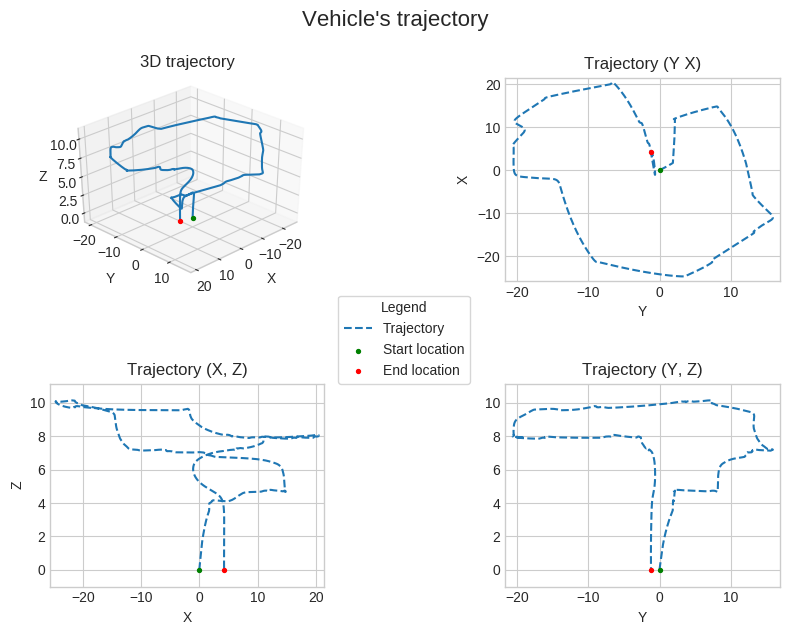

In [10]:
visualize_trajectory(position)

Read Chapter 6, Sections 1 to 3. Section 6.4 is about essential matrix
http://asrl.utias.utoronto.ca/~tdb/bib/barfoot_ser17.pdf
Read Section 5 of a technical report by
https://arxiv.org/pdf/1711.02508.pdf

In [11]:
from rotations import Quaternion, skew_symmetric

In [12]:
orientation = df[orientation_features]
orientation.head()

,field.pose.pose.orientation.x,field.pose.pose.orientation.y,field.pose.pose.orientation.z,field.pose.pose.orientation.w
0,0.000005,-7.756899e-10,-8.347211e-12,1.0
1,0.000005,-7.604584e-10,-8.351686e-12,1.0
2,0.000005,-7.509184e-10,-8.356080e-12,1.0
3,0.000005,-7.482835e-10,-8.360472e-12,1.0
4,0.000005,-7.518286e-10,-8.364861e-12,1.0


In [36]:
# Creating one quaternion
list_of_q = orientation.values.tolist()
list_of_q = np.array(list_of_q).T
q_1 = list_of_q[:,1000]
q = Quaternion(w=q_1[3], x=q_1[0], y=q_1[1], z=q_1[2])
q

Quaternion (wxyz): [-0.97069, -0.03715, -0.20604, 0.11806]

In [37]:
# Print rotation matrix
q.to_mat()

array([[0.8872207756097488, array([0.24450226]), array([0.3912262])],
       [array([-0.21388816]), 0.9693647546207207, array([-0.12076353])],
       [array([-0.40876785]), array([0.02346526]), 0.9123366865033061]],
      dtype=object)

In [38]:
# Print euler angles, roll pitch and yaw
q.to_euler()

array([ 0.02571429,  0.42110355, -0.23656268])

In [39]:
q = Quaternion(euler=q.to_euler())
q

Quaternion (wxyz): [0.97069, 0.03715, 0.20604, -0.11806]

In [ ]:
def visualize_trajectory(df_values):
    
    # Unpack X Y Z each trajectory point
    list_of_pos = df_values.values.tolist()
    trajectory = np.array(list_of_pos).T

    #list for x, y and z values
    locX = list(trajectory[0,:])
    locY = list(trajectory[1,:])
    locZ = list(trajectory[2,:])
    
    # Axis limits
    maxX = np.amax(locX) + 1
    minX = np.amin(locX) - 1
    maxY = np.amax(locY) + 1
    minY = np.amin(locY) - 1 
    maxZ = np.amax(locZ) + 1
    minZ = np.amin(locZ) - 1

    # Set styles
    mpl.rc("figure", facecolor="white")
    plt.style.use("seaborn-whitegrid")

    # Plot the figure
    fig = plt.figure(figsize=(8, 6), dpi=100)
    gspec = gridspec.GridSpec(2, 2)
    ZY_plt = plt.subplot(gspec[1,1])
    YX_plt = plt.subplot(gspec[0,1])
    ZX_plt = plt.subplot(gspec[1,0])
    D3_plt = plt.subplot(gspec[0,0], projection='3d')
    
    toffset = 1.0
    
    # Actual trajectory plotting ZX
    
    ZX_plt.set_title("Trajectory (X, Z)", y=toffset)
    ZX_plt.plot(locX, locZ, "--", label="Trajectory", zorder=1, linewidth=1.5, markersize=2)
    ZX_plt.set_xlabel("X")
    ZX_plt.set_ylabel("Z")
    # Plot camera initial location
    ZX_plt.scatter([0], [0], s=8, c="green", label="Start location", zorder=2)
    ZX_plt.scatter(locX[-1], locZ[-1], s=8, c="red", label="End location", zorder=2)
    ZX_plt.set_xlim([minX, maxX])
    ZX_plt.set_ylim([minZ, maxZ])
    ZX_plt.legend(bbox_to_anchor=(1.05, 1.0), loc=3, title="Legend", borderaxespad=0., fontsize="medium", frameon=True)
        
    # Plot ZY
    ZY_plt.set_title("Trajectory (Y, Z)", y=toffset)
    ZY_plt.set_xlabel("Y")
    ZY_plt.plot(locY, locZ, "--", linewidth=1.5, markersize=2, zorder=1)
    ZY_plt.scatter([0], [0], s=8, c="green", label="Start location", zorder=2)
    ZY_plt.scatter(locY[-1], locZ[-1], s=8, c="red", label="End location", zorder=2)
    ZY_plt.set_xlim([minY, maxY])
    ZY_plt.set_ylim([minZ, maxZ])
    
    # Plot YX
    YX_plt.set_title("Trajectory (Y X)", y=toffset)
    YX_plt.set_ylabel("X")
    YX_plt.set_xlabel("Y")
    YX_plt.plot(locY, locX, "--", linewidth=1.5, markersize=2, zorder=1)
    YX_plt.scatter([0], [0], s=8, c="green", label="Start location", zorder=2)
    YX_plt.scatter(locY[-1], locX[-1], s=8, c="red", label="End location", zorder=2)
    YX_plt.set_xlim([minY, maxY])
    YX_plt.set_ylim([minX, maxX])

    # Plot 3D
    D3_plt.set_title("3D trajectory", y = 1.1)
    D3_plt.plot3D(xs = locX, ys = locY, zs = locZ, zorder=0)
    D3_plt.scatter(0, 0, 0, s=8, c="green", zorder=1)
    D3_plt.scatter(locX[-1], locY[-1], locZ[-1], s=8, c="red", zorder=1)
    D3_plt.set_xlim3d(minX, maxX)
    D3_plt.set_ylim3d(minY, maxY)
    D3_plt.set_zlim3d(minZ, maxZ)
    D3_plt.tick_params(direction='out', pad=-2)
    D3_plt.set_xlabel("X", labelpad=0)
    D3_plt.set_ylabel("Y", labelpad=0)
    D3_plt.set_zlabel("Z", labelpad=-5)
    
    # Plotting the result
    fig.suptitle("Vehicle's trajectory", fontsize=16, y = 1.05)
    D3_plt.view_init(35, azim=45)
    plt.tight_layout()
    plt.show()